In [3]:
import os
import numpy as np
import pandas as pd
import pymc3 as pm
cov = pm.gp.cov
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

sns.set_context("notebook")

In [4]:
marathon_results = pd.read_csv('../data/marathon.csv', index_col=0)[['Age', 'M/F', 'Official Time']]
marathon_results['time_hours'] = pd.to_timedelta(marathon_results['Official Time']).dt.seconds / 3600
marathon_results['female'] = marathon_results['M/F']=='F'
marathon_results = marathon_results[['Age', 'female', 'time_hours']].rename({'Age':'age'}, axis=1)
marathon_results.head()

age  female  time_hours
0   25   False    2.154722
1   30   False    2.163333
2   29   False    2.172778
3   28   False    2.179722
4   32   False    2.180278

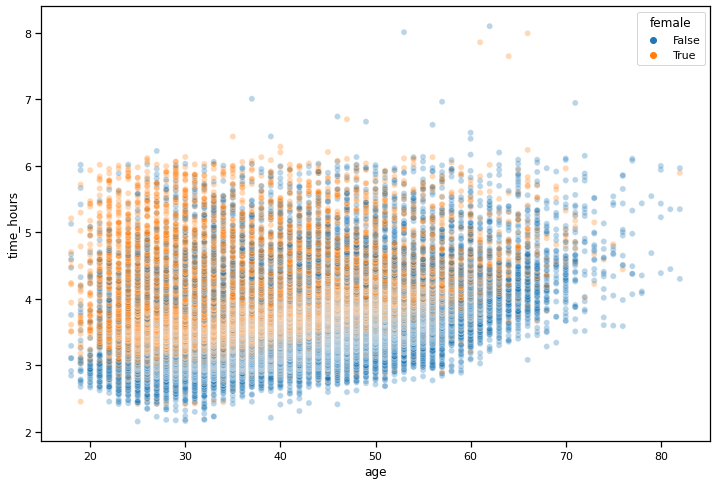

In [5]:
plt.figure(figsize=(12,8))
sns.scatterplot('age', 'time_hours', hue='female', data=marathon_results, alpha=0.3);

In [6]:
x, y = marathon_results.loc[marathon_results.female==True, ['age', 'time_hours']].values.T

In [7]:
with pm.Model() as marathon_model:

    rho = pm.Exponential('ρ', 1)
    nu = pm.Exponential('η', 1)

    K = nu * nu * pm.gp.cov.ExpQuad(1, rho)

    gp = pm.gp.MarginalSparse(cov_func=K, approx="FITC")

    # initialize 20 inducing points with K-means
    Xu = pm.gp.util.kmeans_inducing_points(10, x.reshape(-1,1))

    sigma = pm.HalfCauchy("σ", beta=1)
    obs = gp.marginal_likelihood("obs", X=x.reshape(-1,1), Xu=Xu, y=y, noise=sigma)

In [8]:
with marathon_model:
    
    trace_women = pm.sample(100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, η, ρ]


In [ ]:
X_pred = np.linspace(20, 80)

with marathon_model:
    
    f_pred = gp.conditional('f_pred', X_pred.reshape(-1, 1))